<a href="https://colab.research.google.com/github/rkurdyumov/control_challenges/blob/main/inverted_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install slycot   # Install python-control dependencies for Colab.
!pip install control

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control

In [27]:
# Inverted pendulum parameters, taken from:
# https://github.com/janismac/ControlChallenges/blob/gh-pages/js/models/SinglePendulum.js
m0 = 10.0 # cart mass (kg)
m1 = 0.5  # pendulum mass (kg)
g = 9.81  # (m/s^2)
L = 1.0   # pendulum length (m)

# State space representation of the inverted pendulum on a cart, with state 
# vector z = [dx0, ddx0, dtheta, ddtheta].
A = np.array([
    [0, 1,  0,               0],
    [0, 0, -m1*g/m0,  0],
    [0, 0,  0,               1],
    [0, 0, (m0+m1)*g/(m0*L), 0]])

B = np.array([
    [0],
    [1/m0],
    [0],
    [-1/(m0*L)]])

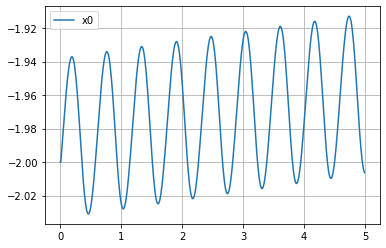

In [96]:
def derivative(m0, m1, L, g, theta, dtheta, F):
  # Solve the equations of motion to get ddx0 and ddtheta:
  #   (m0 + m1)*ddx0 + m1*L*cos(theta)*ddtheta - m1*L*dtheta^2*sin(theta) = F
  #   L*ddtheta + cos(theta) * ddx0 = g*sin(theta) 
  A = np.array([
      [m0 + m1,       m1*L*np.cos(theta)],
      [np.cos(theta), L]
  ])
  b = np.array([F + m1*L*np.sin(theta)*dtheta**2, g*np.sin(theta)])
  return np.linalg.solve(A,b)

def solve_ode(t, z0, K=None):
  x0, dx0, theta, dtheta = z0
  z = np.array(z0)
  uout = [0]
  for i, _ in enumerate(t[1:]):
    dt = t[i] - t[i-1]
    u = 0 if K is None else np.dot(-K, np.array([x0, dx0, theta, dtheta]))
    uout.append(u)
    ddx0, ddtheta = derivative(m0, m1, L, g, theta, dtheta, u)
    x0 += dx0 * dt
    dx0 += ddx0 * dt
    theta += dtheta * dt
    dtheta += ddtheta * dt
    z = np.vstack((z, np.array([x0, dx0, theta, dtheta])))
  return z.transpose(), uout

t = np.arange(0, 5.0, 0.01)
K = np.array([100, 120,  762, 244])
z, u = solve_ode(t, [-2, 0, 0.2, 0])
x0, dx0, theta, dtheta = z
plt.plot(t, x0, label="x0")
#plt.plot(t, u, label="u")
plt.legend()
plt.grid()

[[-100.         -120.16301106 -762.19526958 -243.6292226 ]]


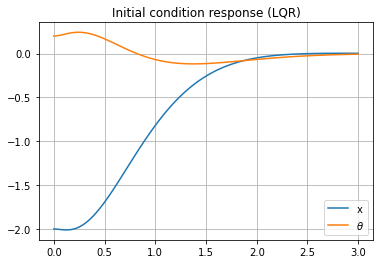

In [23]:
# LQR

# Q assigns weights to errors in each state variable.
Q = np.diag([10000, 1000, 1000, 1000])  # Trial & error but exceeds Fmax = 50N.
# R assigns a weight to the control effort.  Since the relative value of Q and
# R determines the error/effort tradeoff, scale the Q values and leave R as 1.
R = 1

K, S, E = control.lqr(A, B, Q, R)
print(K)
C = np.diag([1, 1, 1, 1])  # Output all states.
sys_lqr = control.ss(A-B*K, B, C, 0)
t = np.linspace(0, 3.0, 100)
z0 = [-2, 0, 0.2, 0] # [x0, dx0, theta0, dtheta0]
t, y_lqr = control.initial_response(sys_lqr, t, z0)
x, dx, theta, dtheta = y_lqr

plt.plot(t, x, label="x")
plt.plot(t, theta, label=r"$\theta$")
plt.title("Initial condition response (LQR)")
plt.legend()
plt.grid()
